Implement and test the 3 conditions of Schaal14 for shock detection

In [1]:
import Utilities.prelude
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import math
import k3match
from Utilities.operators_interp import make_tree, calc_grad, f_interp

In [19]:
gamma = 5/3
mach_min = 1.3
save = False
folder = 'sedov'
m = 5
snap = '100'
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    threshold = 7_000
else:
    is_tde = False
    threshold = 0.99

In [3]:
def temperature_bump(mach, gamma):
    """ T_post/ T_pre shock according to RH conditions."""
    Tbump =  (mach**2 * (gamma-1) + 2) * (2 * gamma * mach**2 - (gamma-1)) / (mach**2 * (gamma+1)**2)
    return Tbump

def pressure_bump(mach, gamma):
    """ P_post/ P_pre shock according to RH conditions."""
    Pbump = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1)
    return Pbump

def shock_direction(sim_tree, fx_tree, fy_tree, fz_tree, X, Y, Z, point, delta):
    """ Find shock direction according eq.(5) by Schaal14 in the point of coordinates indices idx.
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Temp: arrays.
            Coordinates and temperature of the points of the tree.
    point: array.
            Starting point.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    grad: array.
        Gradient of temperature(vector of 3 components).
    ds: array.
        Shock direction (vector of 3 components).
    """
    grad = calc_grad(sim_tree, fx_tree, fy_tree, fz_tree, X, Y, Z, point, delta, operator = 'grad')
    magnitude = np.linalg.norm(grad)
    
    if np.linalg.norm(grad) < 1e-3:
        ds = np.zeros(3)
    else:
        ds = - np.divide(grad,magnitude)

    return grad, ds
 
def find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction):
    """
    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose pre or post shock.
    Returns
    -----------
    idx: int.
        Index of the pre/post shock point
    """
    if direction == 'post':
        delta = - delta

    k = 1
    # check that you are not taking the same point as the one given
    distance = 0
    while distance == 0:
        new_point = point + k * delta * ds 
        _, idx  = sim_tree.query(new_point)
        check_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(point, check_point)
        k += 0.1

    return idx

def condition3(sim_tree, X, Y, Z, Press, Temp, point, ds, mach_min, gamma, delta):
    """ Last condition fot shock zone by Schaal14 .
    Parameters
    -----------
    sim_tree: tree.
            Simulation points.
    X, Y, Z, Press, Temp: arrays.
            Coordinates, pressure and temperature of the points of the tree.
    point: array.
            Starting point.
    ds: array (1x3)
        Shock direction.
    mach_min, gamma: floats.
                    Minimum mach number, adiabatic index.
    delta: float.
            Step between 2 neighbours.
    Returns
    -----------
    bool.
        If condition is satisfied or not.
    """
    # Find (the index in the tree of) the point in the pre/post shock region.
    idxpost = find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction = 'post') 
    idxpre = find_prepost(sim_tree, X, Y, Z, point, ds, delta, direction = 'pre') 

    # Store data from the tree
    Tpost = Temp[idxpost]
    Ppost = Press[idxpost]
    Tpre = Temp[idxpre]
    Ppre = Press[idxpre]

    # Last condition fot shock zone by Schaal14
    delta_logT = np.log(Tpost) - np.log(Tpre)
    Tjump = temperature_bump(mach_min, gamma)
    Tjump = np.log(Tjump)
    ratioT = delta_logT / Tjump 
    delta_logP = np.log(Ppost)-np.log(Ppre)
    Pjump = pressure_bump(mach_min, gamma)
    Pjump = np.log(Pjump)
    ratioP = delta_logP / Pjump 
    
    if np.logical_and(ratioT >= 1, ratioP >= 1): 
        return True
    else:
        return False
    
def shock_zone(divv, gradT, gradrho, cond3, check_cond = '3'):
    """ Find the shock zone according conditions in Sec. 2.3.2 of Schaal14. 
    In order to test the code, with "check_con" you can decide if checking all or some of the conditions."""
    if check_cond == '1' or check_cond == '2':
        cond3 = True # so you don't check it
        if check_cond == '2':
            cond2 = np.dot(gradT, gradrho)
        else:
            cond2 = 10
    else:
        cond2 = np.dot(gradT, gradrho)

    if np.logical_and(divv<0, np.logical_and(cond2 > 0, cond3 == True)):
        return True
    else:
        return False

In [4]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

In [5]:
# Floor density
# idx = np.argmax(Den)
# xmax = X[idx]
# ymax = Y[idx]
# print(f'The density floor is {np.min(Den)}')
# mindenstream = np.min(Den[np.logical_and(np.abs(ymax-Y)<11,np.abs(xmax-X)<11)])
# print(f'The minimum around the stream is {mindenstream}')

In [6]:
# Elad gradient for Density
Eladx_rholim = np.load(f'{folder}/{snap}/DrhoDxLimited_{snap}.npy')
Elady_rholim = np.load(f'{folder}/{snap}/DrhoDyLimited_{snap}.npy')
Eladz_rholim = np.load(f'{folder}/{snap}/DrhoDzLimited_{snap}.npy')
Eladx_rho = np.load(f'{folder}/{snap}/DrhoDx_{snap}.npy')
Elady_rho = np.load(f'{folder}/{snap}/DrhoDy_{snap}.npy')
Eladz_rho = np.load(f'{folder}/{snap}/DrhoDz_{snap}.npy')

Eladx_plim = np.load(f'{folder}/{snap}/DpDxLimited_{snap}.npy')
Elady_plim = np.load(f'{folder}/{snap}/DpDyLimited_{snap}.npy')
Eladz_plim = np.load(f'{folder}/{snap}/DpDzLimited_{snap}.npy')
Eladx_p = np.load(f'{folder}/{snap}/DpDx_{snap}.npy')
Elady_p = np.load(f'{folder}/{snap}/DpDy_{snap}.npy')
Eladz_p = np.load(f'{folder}/{snap}/DpDz_{snap}.npy')

Elad_divVlim = np.load(f'{folder}/{snap}/divVLimited_{snap}.npy')
Elad_divV = np.load(f'{folder}/{snap}/divV_{snap}.npy')

In [ ]:
Eladx_T = Eladx_p/Den - Press * Eladx_rho/ (Den)**2
Elady_T = Elady_p/Den - Press * Elady_rho/ (Den)**2
Eladz_T = Eladz_p/Den - Press * Eladz_rho/ (Den)**2

In [7]:
shock_dirx = []
shock_diry = []
shock_dirz = []
X_shock1 = []
Y_shock1 = []
Z_shock1 = []
X_shock2 = []
Y_shock2 = []
Z_shock2 = []
X_shock = []
Y_shock = []
Z_shock = []
div_shock = []
T_shock = []
are_u_shock = np.zeros(len(X), dtype = bool)
x_who = []
y_who = []
z_who = []
idx_tree = []
idx_tree1 = []
idx_tree2 = []

masked = 0
for i in range(len(X)):
    # if i%10_000 == 0:
    print(i)
    point = np.array([X[i],Y[i],Z[i]])

    if np.linalg.norm(point)>threshold:
        masked += 1
        are_u_shock[i] = False
        continue 

    step = 0.5*dim_cell[i]
    grad_temp, ds = shock_direction(sim_tree, Eladx_T, Elady_T, Eladz_T, X, Y, Z, point, step)
    grad_den = calc_grad(sim_tree, Eladx_rho, Elady_rho, Eladz_rho, X, Y, Z, point, step)
    div_vel = f_interp(sim_tree, Elad_divV, X, Y, Z, point, step)

###
    gradP = np.array([Eladx_p[i], Elady_p[i], Eladz_p[i]])
    grad_den = np.array([Eladx_rho[i], Elady_rho[i], Eladz_rho[i]]) 
    div_vel = Elad_divV[i] 
    
    grad_temp = np.zeros(3)
    grad_fords = np.zeros(3)
    for k in range(3):
        gradP_fords = np.array([Eladx_p[i], Elady_p[i], Eladz_p[i]])
        grad_den_fords = np.array([Eladx_rho[i], Elady_rho[i], Eladz_rho[i]]) 
        grad_fords[k] = gradP_fords[k]/Den[i] - Press[i] * grad_den_fords[k]/ (Den[i])**2
        
        grad_temp[k] = grad_fords[k]#gradP[k]/Den[i] - Press[i] * grad_den[k]/ (Den[i])**2

    _, ds = shock_direction(grad_fords)
###
    
    # fondamentale!!
    if np.linalg.norm(ds) == 0 or Den[i]<1e-15:
        are_u_shock[i] = False
        continue
    
    if math.isnan(np.linalg.norm(grad_temp)):
        # non dovrebbe succedere se prendi ds=2*max
        are_u_shock[i] = False
        print(f'nan in grad temp of cell {i}, change step')
        x_who.append(X[i])
        y_who.append(Y[i])
        z_who.append(Z[i])
        continue 

    if math.isnan(np.linalg.norm(div_vel)):
        # non dovrebbe succedere per come prendi step in ds=2*max
        are_u_shock[i] = False
        print('nan in div_v')

    cond3 = condition3(sim_tree, X, Y, Z, Press, Temp, point, ds, mach_min, gamma, step)
    shock1 = shock_zone(div_vel, grad_temp, grad_den, cond3, check_cond =  '1')
    shock2 = shock_zone(div_vel, grad_temp, grad_den, cond3, check_cond =  '2')
    shock = shock_zone(div_vel, grad_temp, grad_den, cond3, check_cond = '3')
    are_u_shock[i] = shock
    
    if shock1 == True:
        X_shock1.append(X[i])
        Y_shock1.append(Y[i])
        Z_shock1.append(Z[i])
        idx_tree1.append(i)

    if shock2 == True:
        X_shock2.append(X[i])
        Y_shock2.append(Y[i])
        Z_shock2.append(Z[i])
        idx_tree2.append(i)

    if shock == True:
        X_shock.append(X[i])
        Y_shock.append(Y[i])
        Z_shock.append(Z[i])
        shock_dirx.append(ds[0])
        shock_diry.append(ds[1])
        shock_dirz.append(ds[2])
        div_shock.append(div_vel)
        T_shock.append(Temp[i])
        idx_tree.append(i)

print(masked)      

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

In [8]:
X_shock = np.array(X_shock)
Y_shock = np.array(Y_shock)
Z_shock = np.array(Z_shock)

X_shock1 = np.array(X_shock1)
Y_shock1 = np.array(Y_shock1)
Z_shock1 = np.array(Z_shock1)

X_shock2 = np.array(X_shock2)
Y_shock2 = np.array(Y_shock2)
Z_shock2 = np.array(Z_shock2)

In [9]:
if save == True:
    with open(f'data/{snap}/shockzone_{snap}.txt', 'w') as file:
        file.write(f'# Coordinates of the points in the shock zone, mach_min = {mach_min} \n# X \n') 
        file.write('# Index in the tree \n') 
        file.write(' '.join(map(str, idx_tree)) + '\n')
        file.write('# div v \n') 
        file.write(' '.join(map(str, div_shock)) + '\n')
        file.write('# shock direction x \n') 
        file.write(' '.join(map(str, shock_dirx)) + '\n')
        file.write('# shock direction y \n') 
        file.write(' '.join(map(str, shock_diry)) + '\n')
        file.write('# shock direction z \n') 
        file.write(' '.join(map(str, shock_dirz)) + '\n')
        file.close()

In [10]:
if save == True:
    with open(f'data/{snap}/areushock_{snap}.pkl', 'wb') as filebool:
        pickle.dump(are_u_shock, filebool)

In [11]:
cross_sec = 0
dim_cell_zone = dim_cell[idx_tree]
dim_cell_zone1 = dim_cell[idx_tree1]
dim_cell_zone2 = dim_cell[idx_tree2]

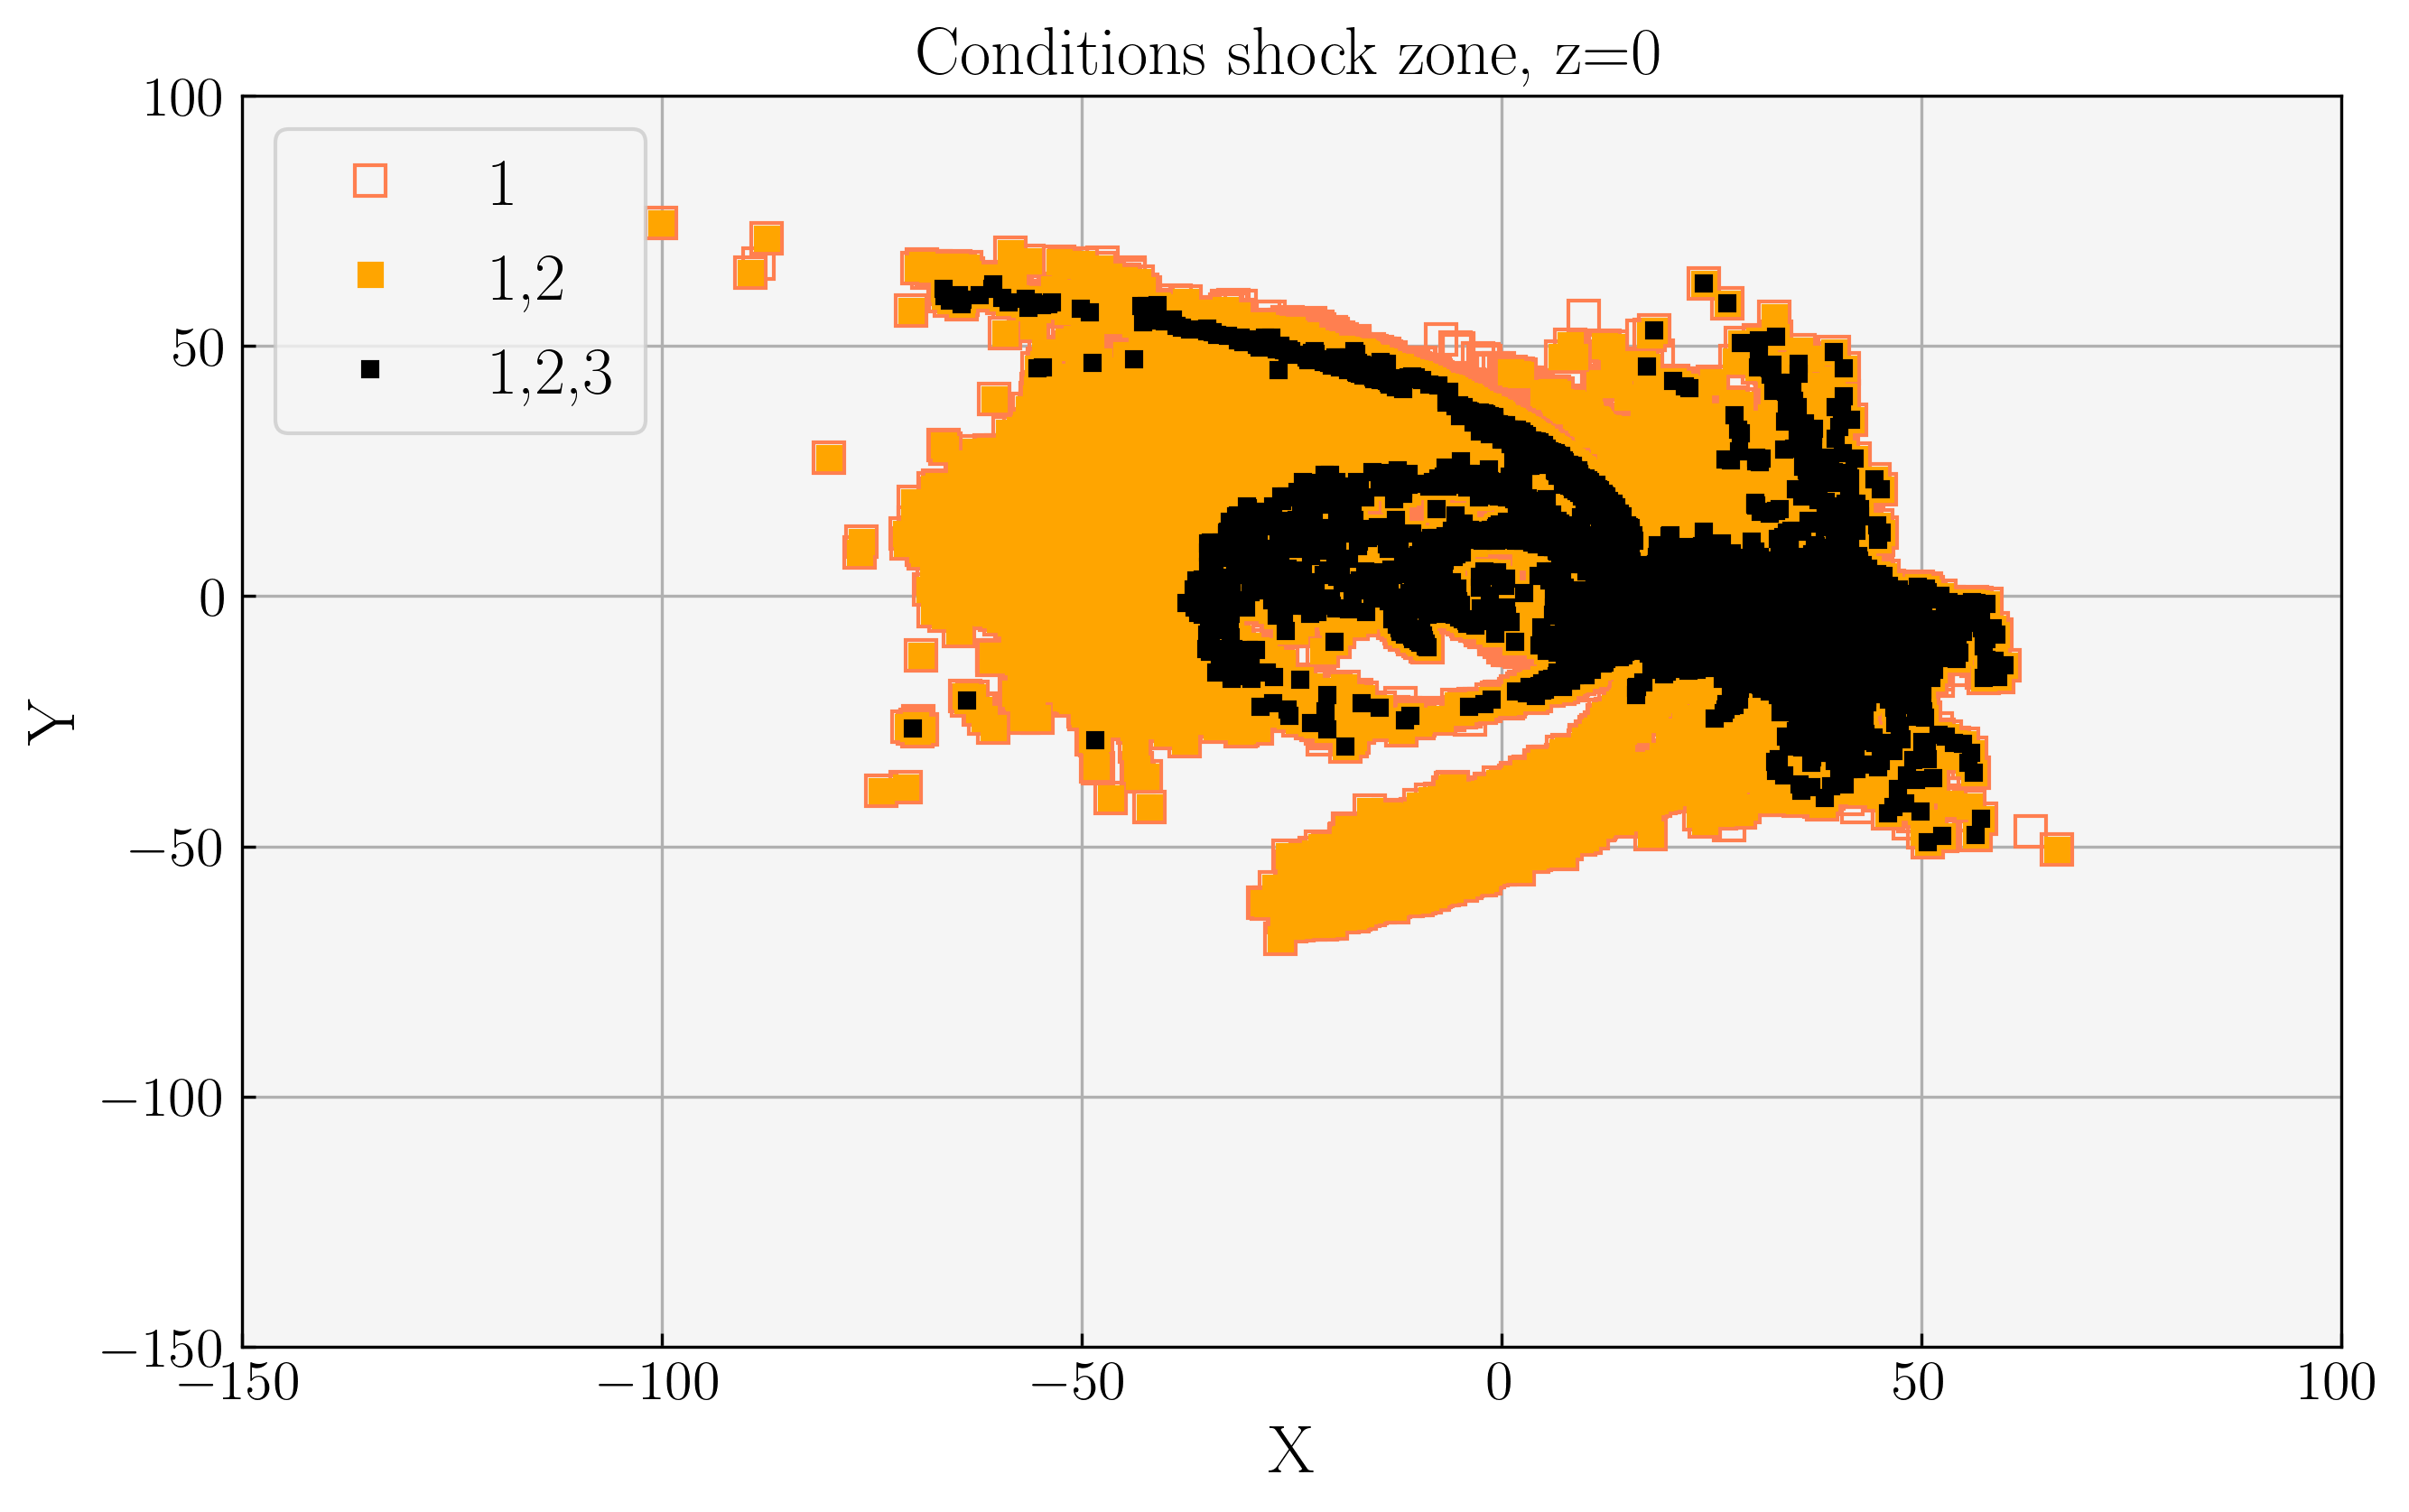

In [23]:
# Plot 3 conditions (cross section)
if(len(X_shock1[np.abs(Z_shock1-cross_sec)<dim_cell_zone1])>1):
    if folder == 'sedov':
        plt.figure(figsize=(10,10))
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
    else:
        plt.figure(figsize=(10,6))
    plt.plot(X_shock1[np.abs(Z_shock1-cross_sec)<dim_cell_zone1], Y_shock1[np.abs(Z_shock1-cross_sec)<dim_cell_zone1], 'ks', markerfacecolor='none', ms=8, markeredgecolor='coral', label = '1')
    plt.plot(X_shock2[np.abs(Z_shock2-cross_sec)<dim_cell_zone2], Y_shock2[np.abs(Z_shock2-cross_sec)<dim_cell_zone2], 'ks', markerfacecolor='orange', ms=6, markeredgecolor='orange', label = '1,2')
    plt.plot(X_shock[np.abs(Z_shock-cross_sec)<dim_cell_zone], Y_shock[np.abs(Z_shock-cross_sec)<dim_cell_zone], 'ks', markerfacecolor='k', ms=4, markeredgecolor='k', label = '1,2,3')
    plt.xlabel('X', fontsize = 18)
    plt.ylabel('Y', fontsize = 18)
    plt.xlim(-150,100)
    plt.ylim(-150,100)
    plt.legend(loc = 'upper left', fontsize = 18)
    plt.grid()
    plt.title(f'Conditions shock zone, z={cross_sec}', fontsize = 18)
    if save:    
        plt.savefig(f'Figs/{snap}/3XYshockzone_conditions_{snap}zoom.png')
    plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_32980/302952970.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Y_shock1[np.abs(X_shock1-cross_sec)<dim_cell_zone1], Z_shock1[np.abs(X_shock1-cross_sec)<dim_cell_zone1], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='b', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_32980/302952970.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(Y_shock2[np.abs(X_shock2-cross_sec)<dim_cell_zone2], Z_shock2[np.abs(X_shock2-cross_sec)<dim_cell_zone2], 'ks', c = 'k', markerfacecolor='turquoise', ms=6, markeredgecolor='turquoise', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_32980/302952970.py:10: UserWarning: color is redundantly de

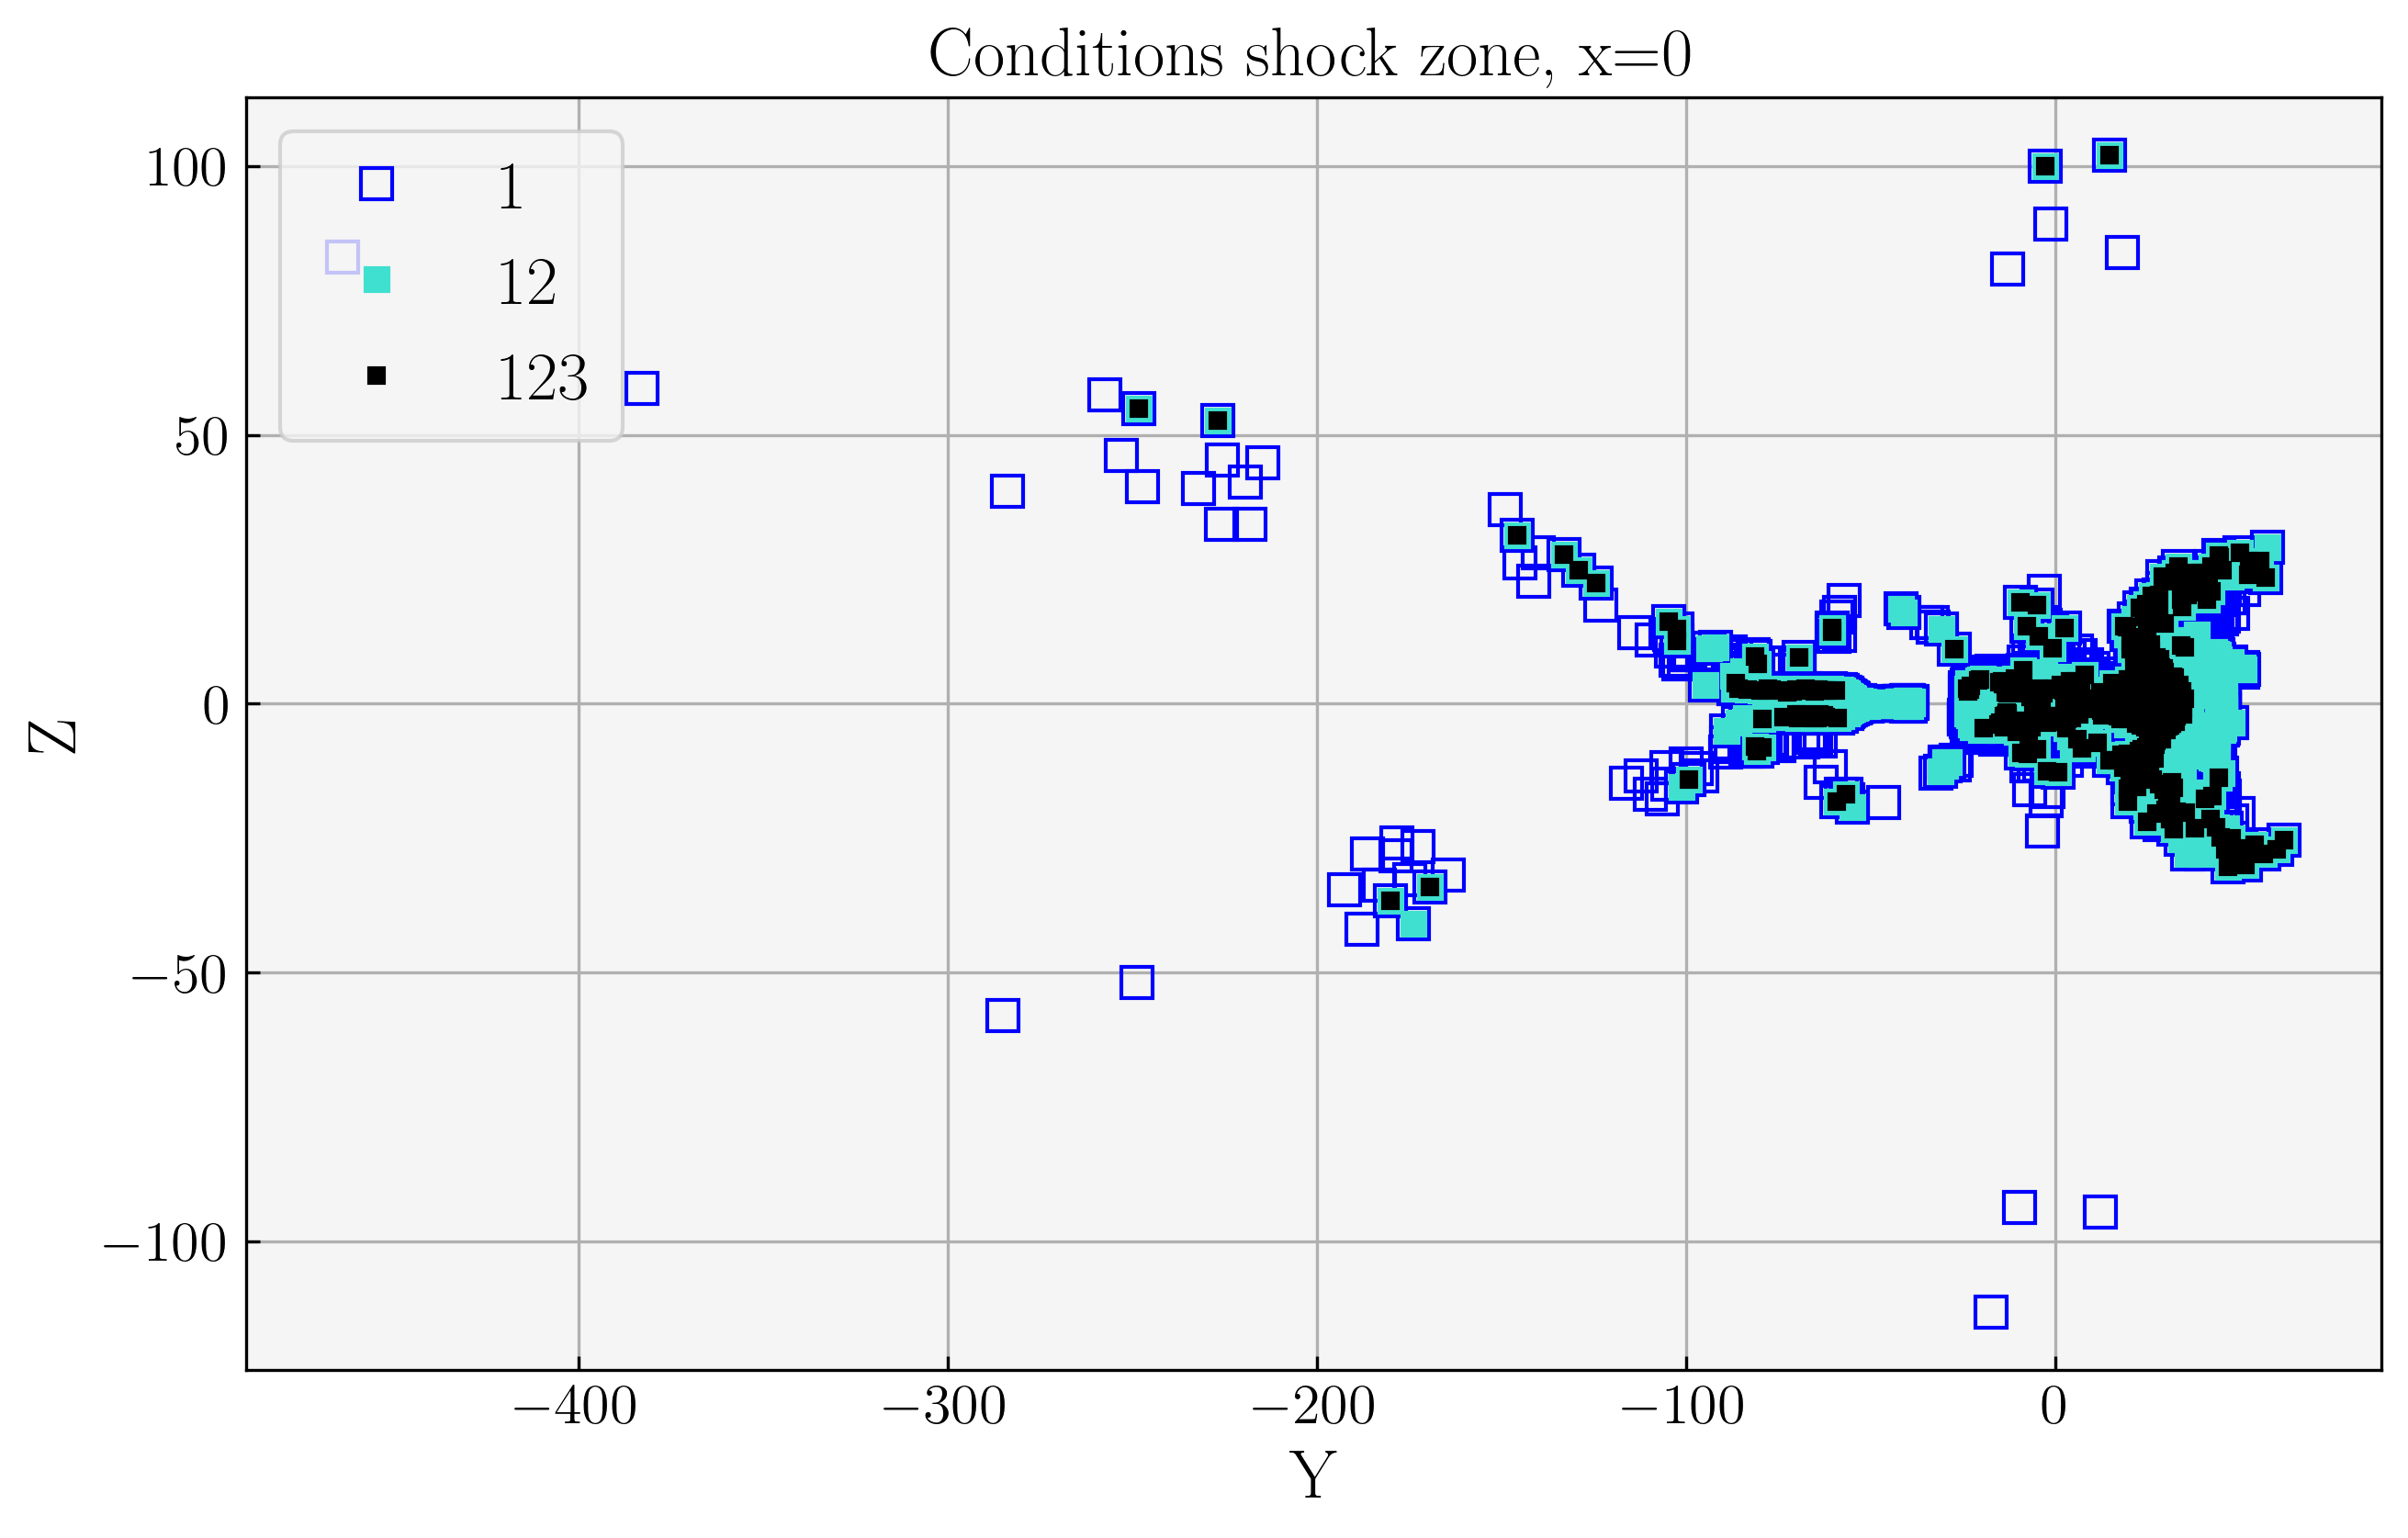

In [13]:
if(len(Y_shock1[np.abs(X_shock1-cross_sec)<dim_cell_zone1])>1):
    if folder == 'sedov':
        plt.figure(figsize=(10,10))
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
    else:
        plt.figure(figsize=(10,6))
    plt.plot(Y_shock1[np.abs(X_shock1-cross_sec)<dim_cell_zone1], Z_shock1[np.abs(X_shock1-cross_sec)<dim_cell_zone1], 'ks', markerfacecolor='none', ms=8, markeredgecolor='b', label = '1')
    plt.plot(Y_shock2[np.abs(X_shock2-cross_sec)<dim_cell_zone2], Z_shock2[np.abs(X_shock2-cross_sec)<dim_cell_zone2], 'ks', markerfacecolor='turquoise', ms=6, markeredgecolor='turquoise', label = '12')
    plt.plot(Y_shock[np.abs(X_shock-cross_sec)<dim_cell_zone], Z_shock[np.abs(X_shock-cross_sec)<dim_cell_zone], 'ks', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
    plt.xlabel('Y', fontsize = 18)
    plt.ylabel('Z', fontsize = 18)
    plt.legend(loc = 'upper left', fontsize = 18)
    plt.grid()
    plt.title(f'Conditions shock zone, x={cross_sec}', fontsize = 18)
    if save:    
        plt.savefig(f'Figs/{snap}/3YZshockzone_conditions_{snap}.png')
    plt.show()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_32980/2027483666.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock1[np.abs(Y_shock1-cross_sec)<dim_cell_zone1], Z_shock1[np.abs(Y_shock1-cross_sec)<dim_cell_zone1], 'ks', c = 'k', markerfacecolor='none', ms=8, markeredgecolor='purple', label = '1')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_32980/2027483666.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ks" (-> color='k'). The keyword argument will take precedence.
  plt.plot(X_shock2[np.abs(Y_shock2-cross_sec)<dim_cell_zone2], Z_shock2[np.abs(Y_shock2-cross_sec)<dim_cell_zone2], 'ks', c = 'k', markerfacecolor='magenta', ms=6, markeredgecolor='magenta', label = '12')
/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_32980/2027483666.py:10: UserWarning: color is redundantl

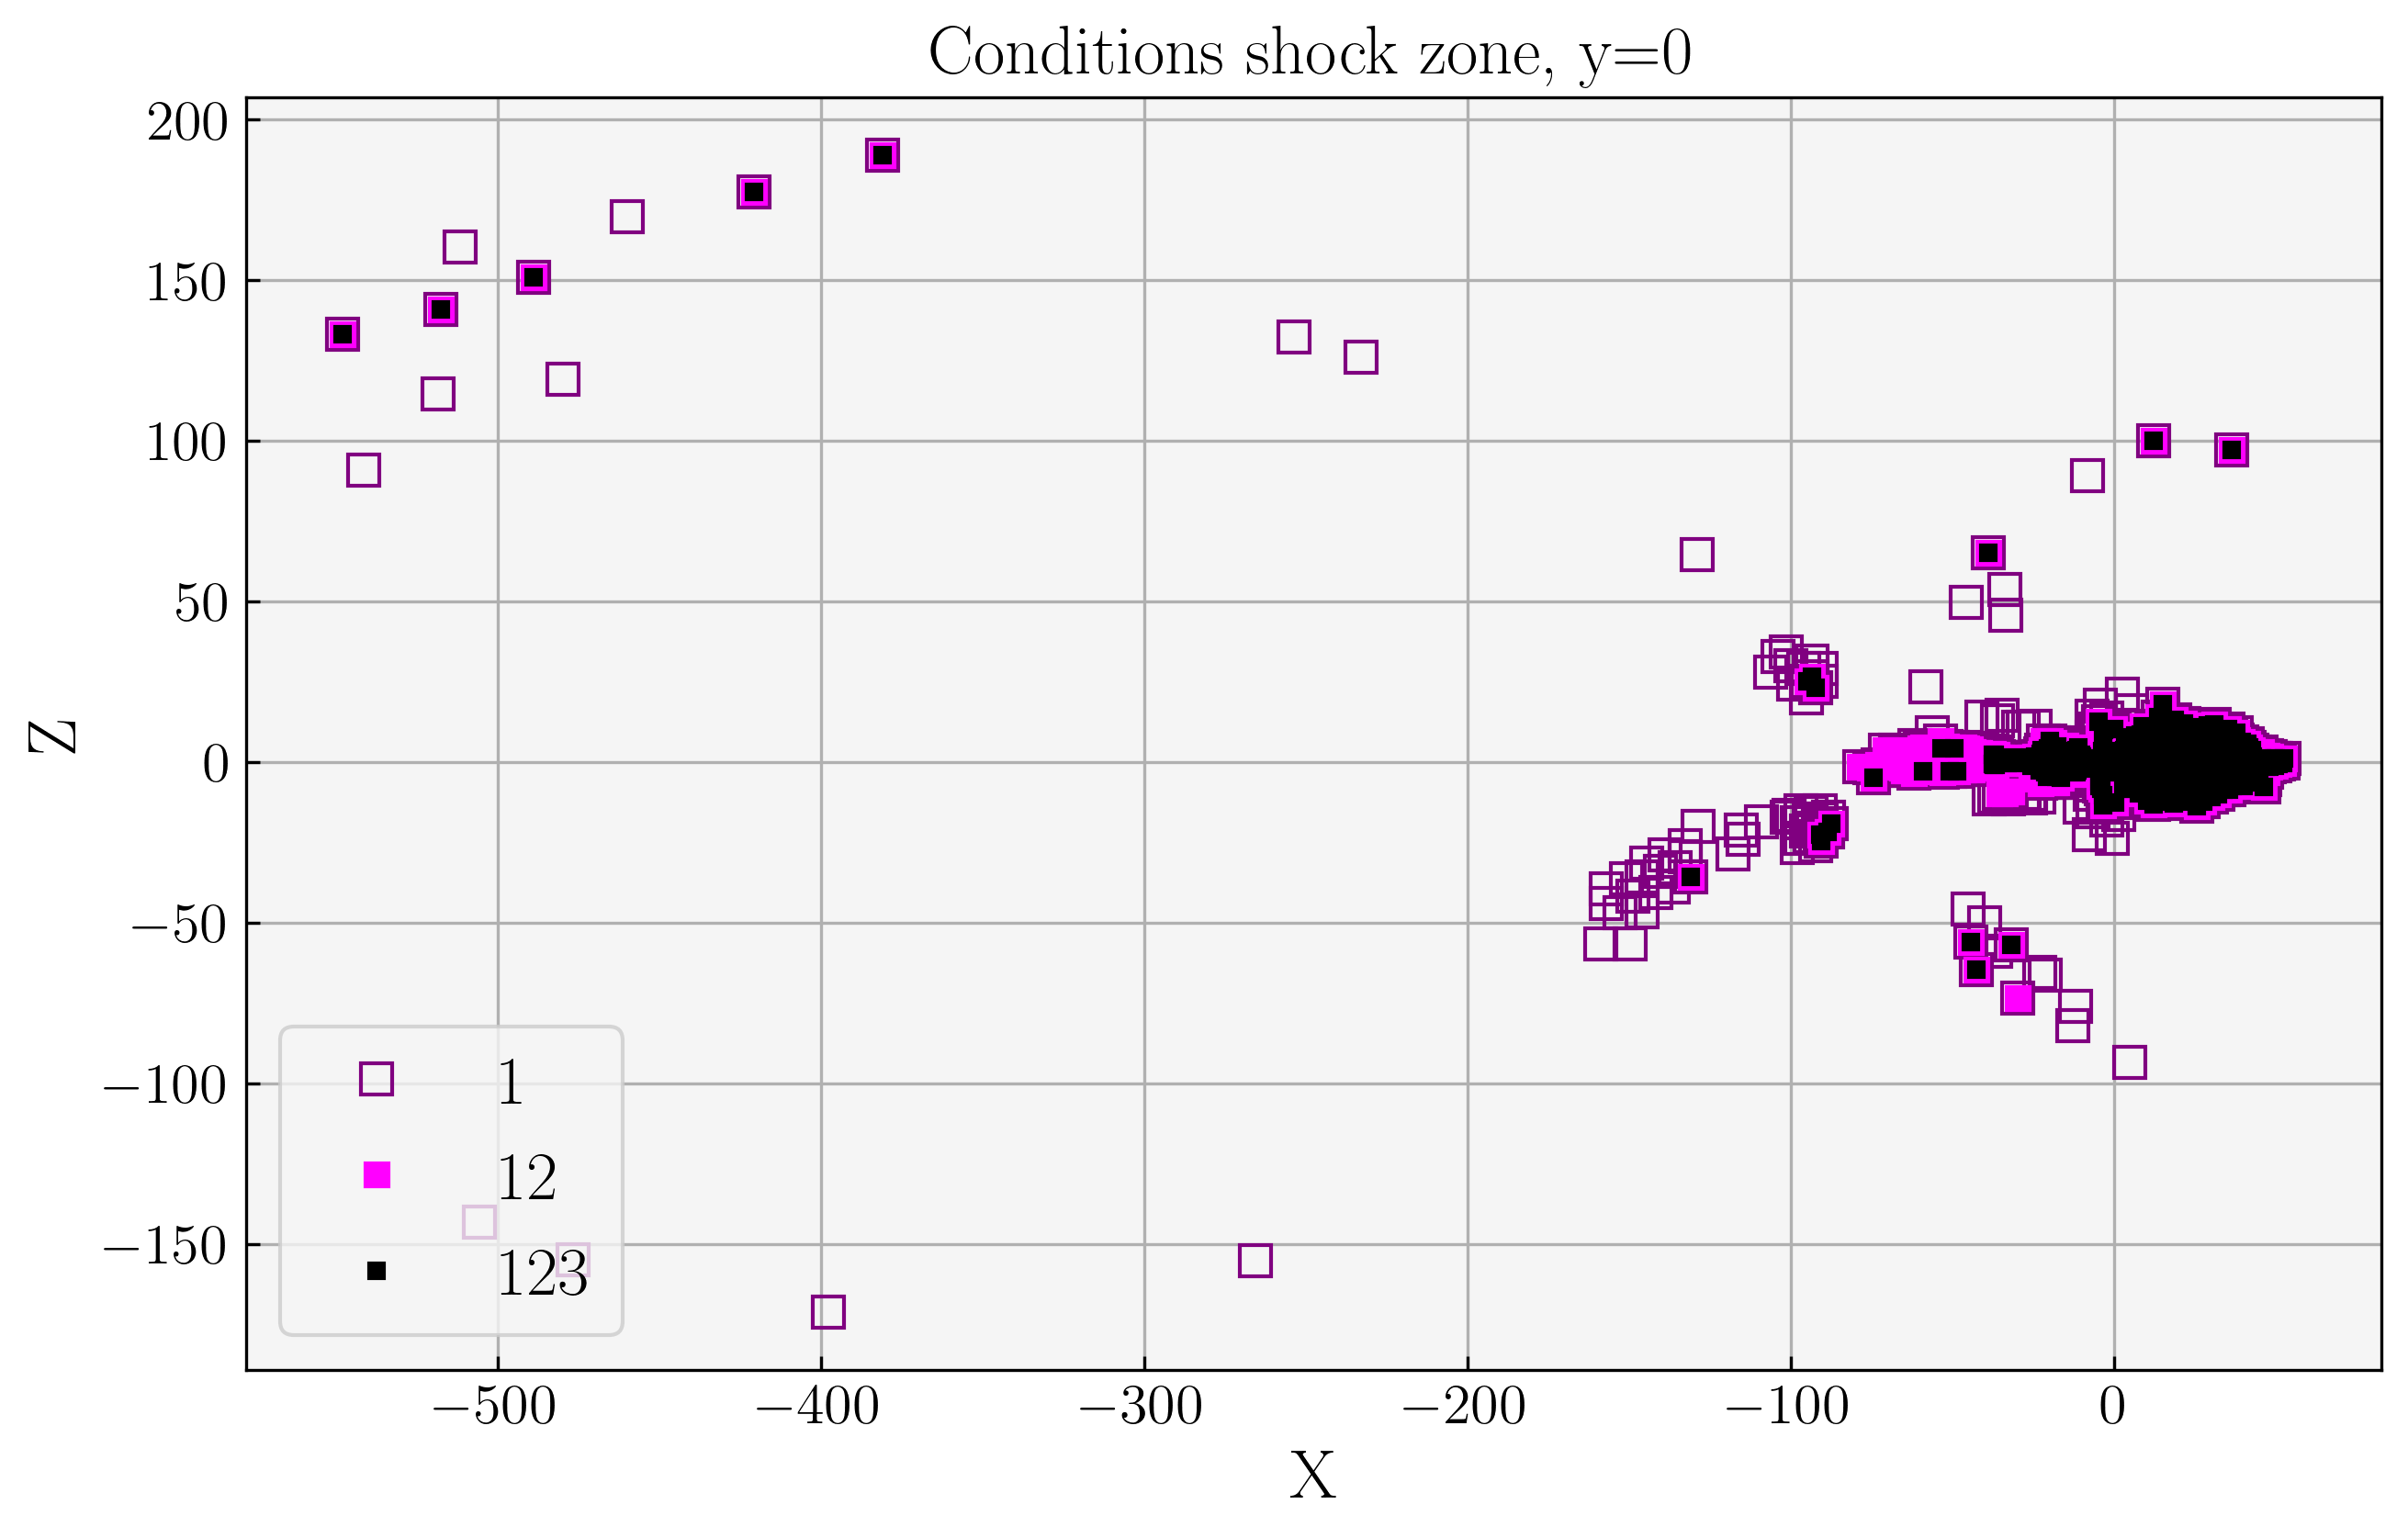

In [14]:
if(len(X_shock1[np.abs(Y_shock1-cross_sec)<dim_cell_zone1])>1):
    if folder == 'sedov':
        plt.figure(figsize=(10,10))
        plt.xlim(-1.1,1.1)
        plt.ylim(-1.1,1.1)
    else:
        plt.figure(figsize=(10,6))
    plt.plot(X_shock1[np.abs(Y_shock1-cross_sec)<dim_cell_zone1], Z_shock1[np.abs(Y_shock1-cross_sec)<dim_cell_zone1], 'ks', markerfacecolor='none', ms=8, markeredgecolor='purple', label = '1')
    plt.plot(X_shock2[np.abs(Y_shock2-cross_sec)<dim_cell_zone2], Z_shock2[np.abs(Y_shock2-cross_sec)<dim_cell_zone2], 'ks', markerfacecolor='magenta', ms=6, markeredgecolor='magenta', label = '12')
    plt.plot(X_shock[np.abs(Y_shock-cross_sec)<dim_cell_zone], Z_shock[np.abs(Y_shock-cross_sec)<dim_cell_zone], 'ks', markerfacecolor='k', ms=4, markeredgecolor='k', label = '123')
    plt.xlabel('X', fontsize = 18)
    plt.ylabel('Z', fontsize = 18)
    plt.legend(loc = 'lower left', fontsize = 18)
    plt.grid()
    plt.title(f'Conditions shock zone, y={cross_sec}', fontsize = 18)
    if save:    
        plt.savefig(f'Figs/{snap}/3XZshockzone_conditions_{snap}.png')
    plt.show()

m=5, apocenter = 4308.869380063766


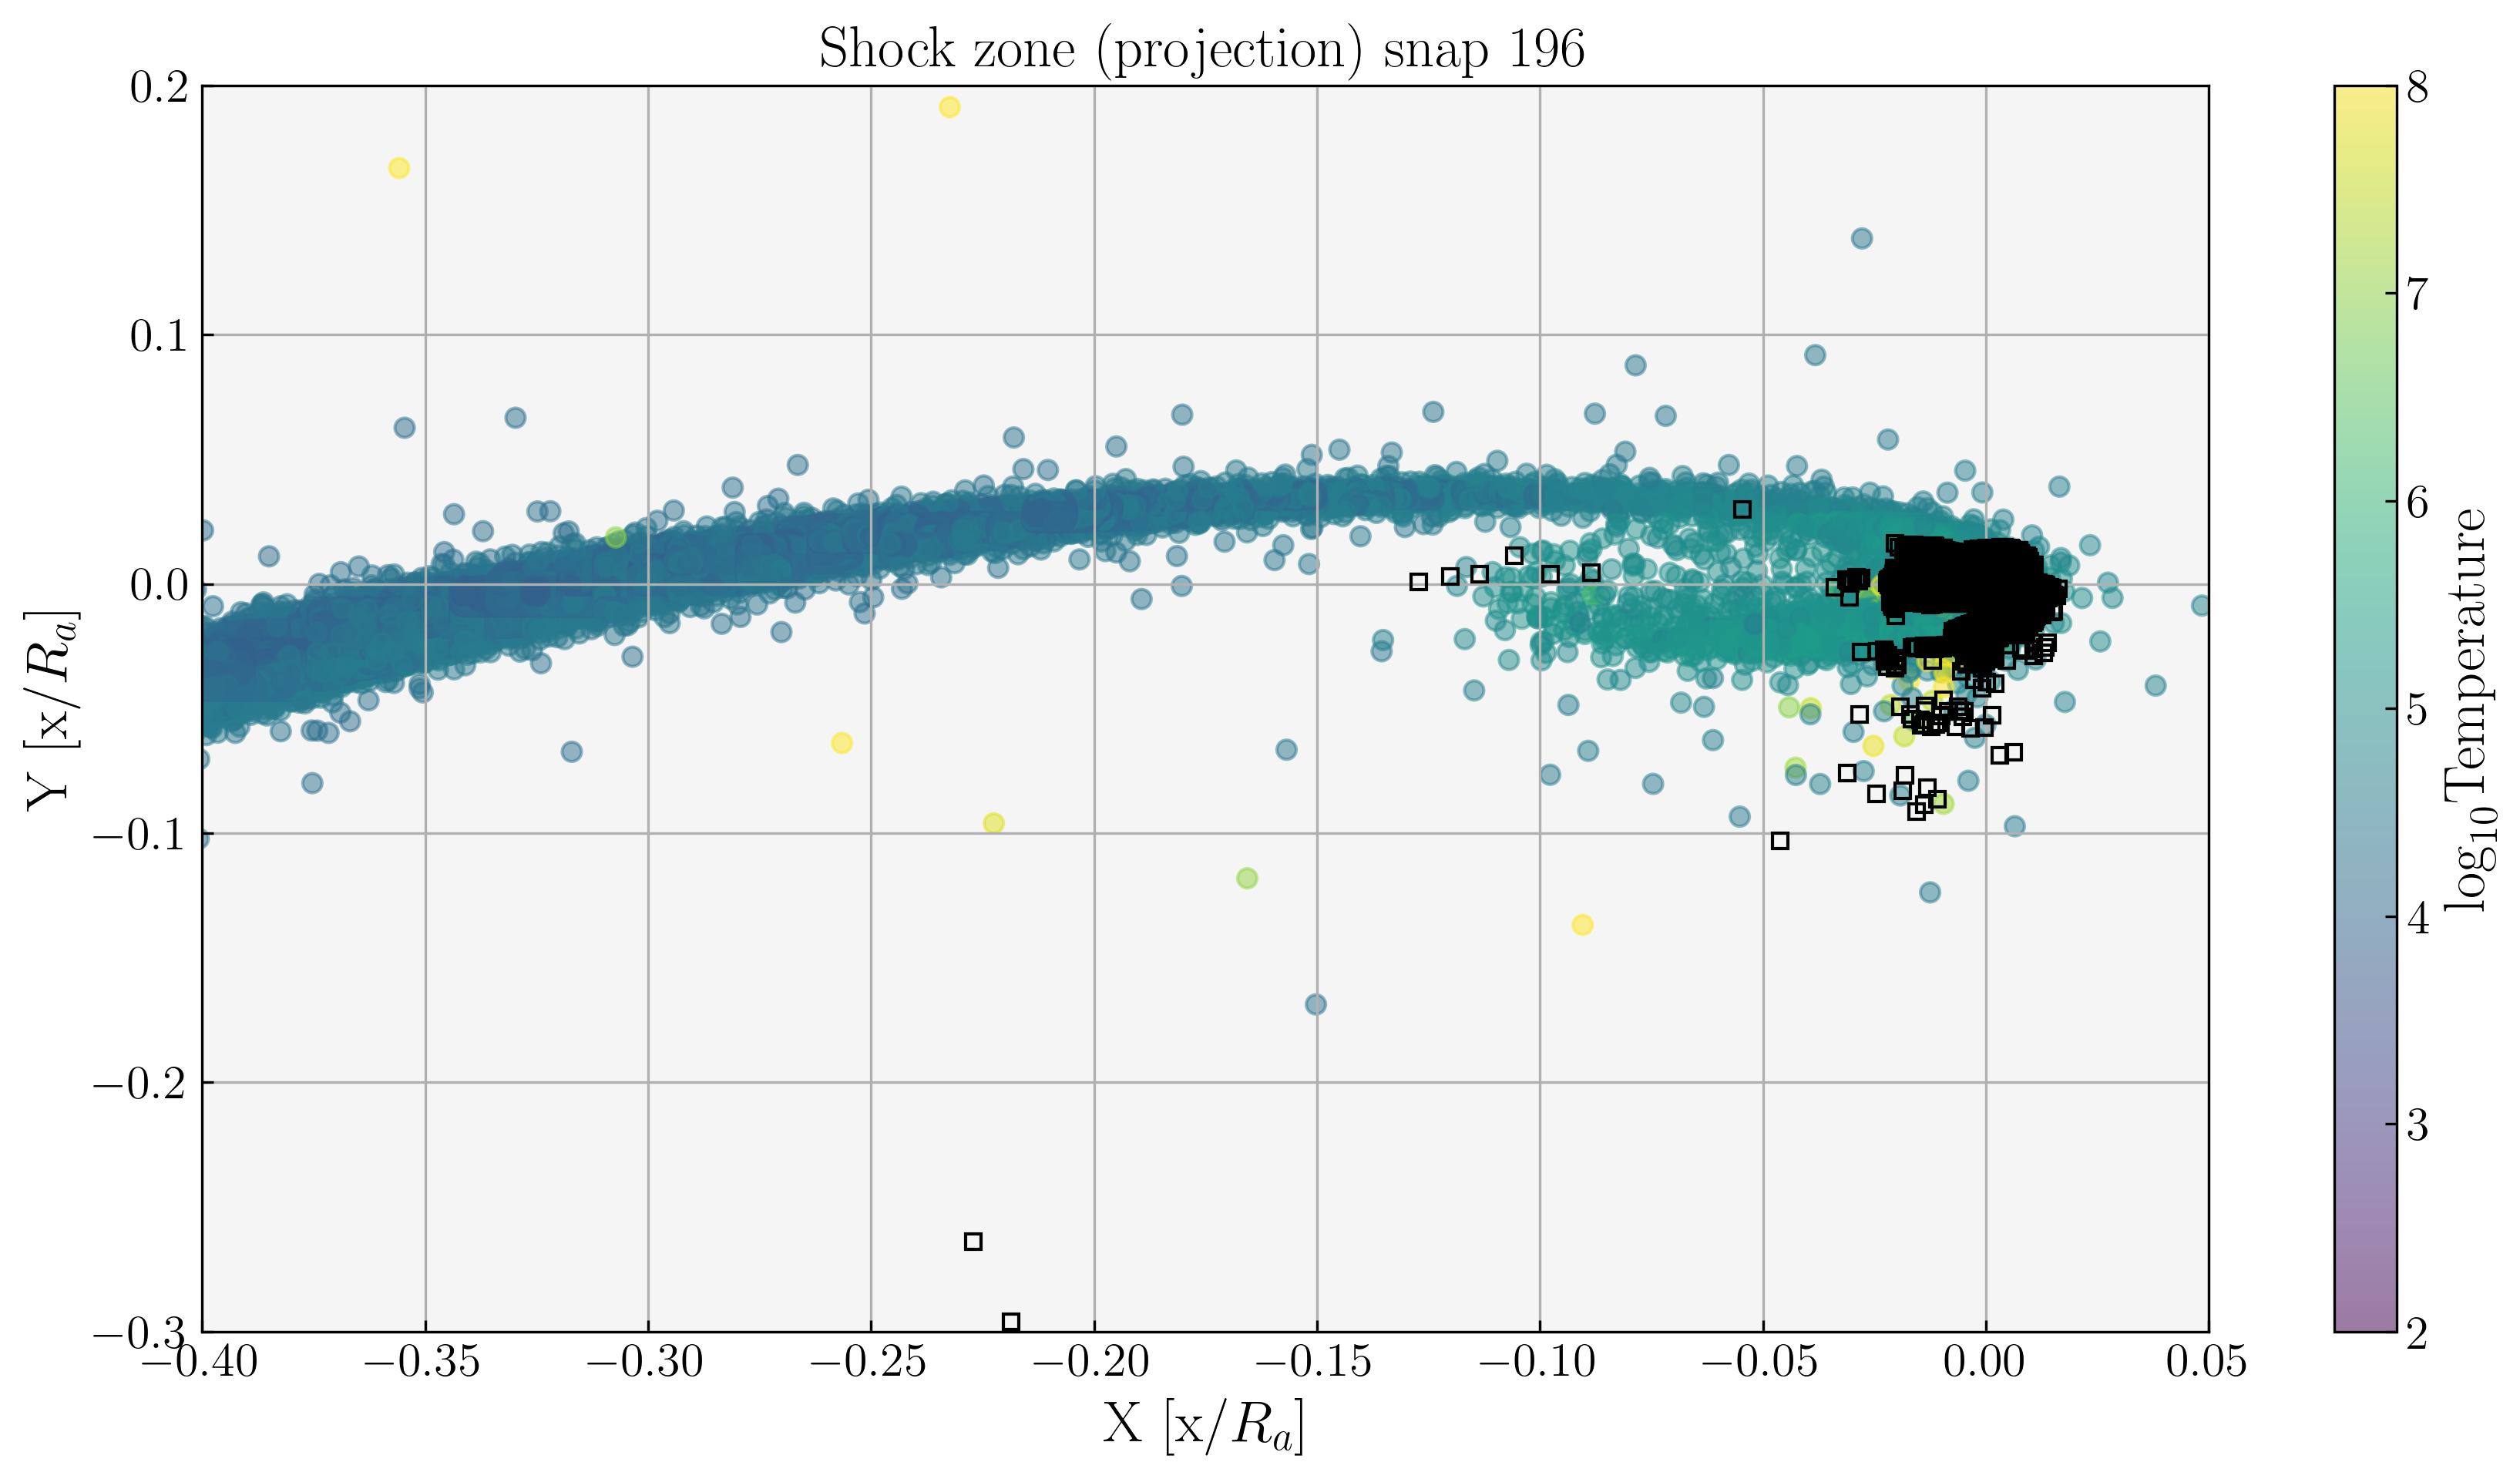

In [21]:
if folder == 'sedov':
    plt.figure(figsize=(8,8))
    plt.plot(X_shock[np.abs(Z_shock-cross_sec)<dim_cell_zone], Y_shock[np.abs(Z_shock-cross_sec)<dim_cell_zone], 'ks', c = 'k', markerfacecolor='k', ms=5, markeredgecolor='k')
    plt.xlabel('X', fontsize = 18)
    plt.ylabel('Y', fontsize = 18)
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.title(f'Shock zone, z = {cross_sec}', fontsize = 18)

if folder == 'TDE':
    Mbh = 10**m 
    Rt =  Mbh**(1/3) # Msol = 1, Rsol = 1
    apocenter = 2 * Rt * Mbh**(1/3)
    print(f'm={m}, apocenter = {apocenter}')
    plt.figure(figsize=(14,7))
    img = plt.scatter(X[::200]/apocenter, Y[::200]/apocenter, c = np.log10(Temp[::200]), alpha = 0.5, vmin = 2, vmax = 8)
    cbar = plt.colorbar(img)
    cbar.set_label(r'$\log_{10}$Temperature', fontsize = 18)
    plt.plot(X_shock/apocenter, Y_shock/apocenter, 'ks',  markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
    plt.xlabel(r'X [x/$R_a$]', fontsize = 18)
    plt.ylabel(r'Y [x/$R_a$]', fontsize = 18)
    plt.ylim(-0.3, 0.2)
    plt.xlim(-0.4,0.05)
    plt.title(f'Shock zone (projection) snap {snap}', fontsize = 18)

plt.grid()
if save:
    plt.savefig(f'Figs/{snap}/shockzone_{snap}.png')
plt.show()

In [16]:
if(len(x_who)>1):
    x_who = np.array(x_who)
    y_who = np.array(y_who)
    z_who = np.array(z_who)

    plt.figure(figsize=(10,10))
    plt.scatter(x_who, y_who,  c = 'b', label = 'wrong')
    plt.plot(X_shock, Y_shock, 'ks', c = 'k', markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
    plt.xlim(-1.1,1.1)
    plt.ylim(-1.1,1.1)
    plt.xlabel('X', fontsize = 18)
    plt.ylabel('Y', fontsize = 18)
    plt.legend()
    plt.grid()
    plt.title(r'Is ds = nan?', fontsize = 18)
    plt.legend()
    if save:
        plt.savefig(f'Figs/{snap}/4who_{snap}.png')
    plt.show()